# Building a SMS Spam filter with Naive Bayes Algorithm
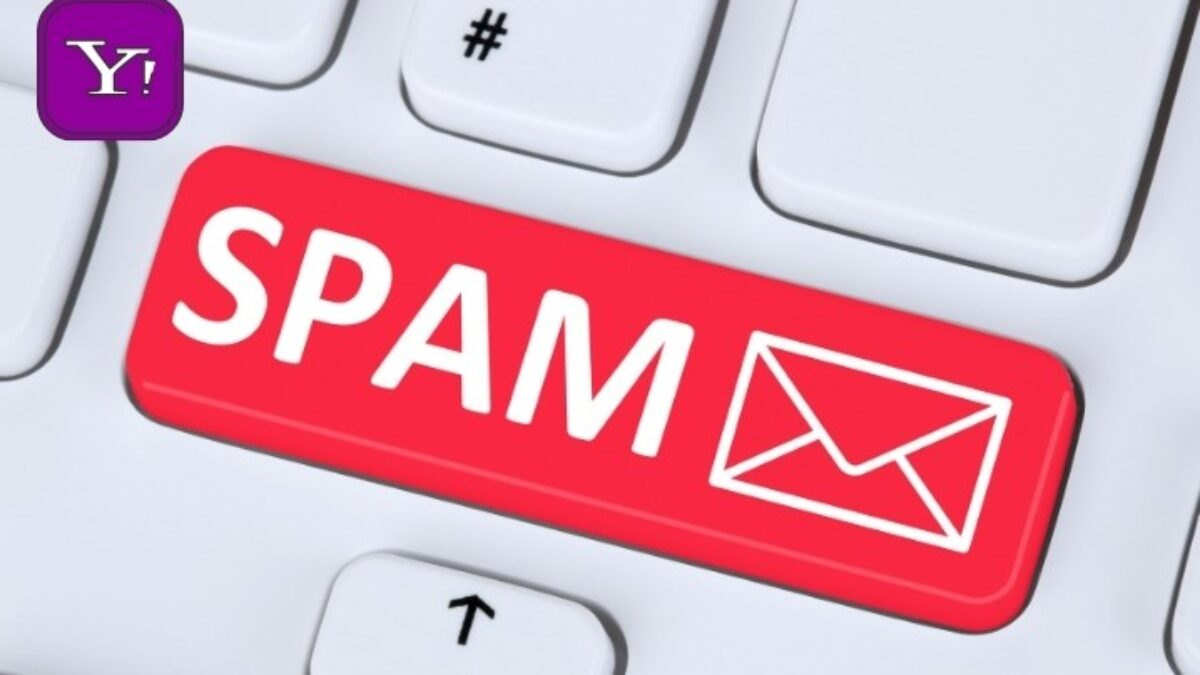

<center>Source:https://readus247.com/fix-yahoo-mail-spam-filter-not-working</center>
    
## I. Introduction
The Native Bayes algorithm has been known widely to be a simple, yet effective tool to calculate conditional probabilities and is applied in many machine learning problems. The details of the algorithm will be explained in section  __"4. Apply Naive Bayes Algorithm"__.

In this guided project, we are going to use __Multinomial Naive Bayes__ to build a spam filter based on 5572 SMS messages that are already classfied by human. This SMS dataset was collected by Tiago A. Almeida and José María Gómez Hidalgo.

## II. Analysis

First let's explore the dataset. We will print out the # of rows in the dataset

In [425]:
import pandas as pd

In [426]:
sms = pd.read_csv('SMSSpamCollection', sep='\t', header=None, names=['Label','SMS'])
print(sms.head(10))
print(sms.shape)


  Label                                                SMS
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...
5  spam  FreeMsg Hey there darling it's been 3 week's n...
6   ham  Even my brother is not like to speak with me. ...
7   ham  As per your request 'Melle Melle (Oru Minnamin...
8  spam  WINNER!! As a valued network customer you have...
9  spam  Had your mobile 11 months or more? U R entitle...
(5572, 2)


Next, we will calculate the percentage of spam and ham message

In [427]:
spam_percent = sms['Label'].value_counts()['spam'] / len(sms) * 100
ham_percent = sms['Label'].value_counts()['ham'] / len(sms) * 100

print('Percentage of spam messages:', spam_percent,'%')
print('Percentage of ham messages:', ham_percent,'%')

Percentage of spam messages: 13.406317300789663 %
Percentage of ham messages: 86.59368269921033 %


About __87%__ are spam and __13%__ are ham

### 1. Split into test and train set
When creating a software, a good rule of thumb is that designing the test comes before creating the software. After building the spam filter, we need to test how well the filters. Therefor we need toi split the dataset into test and train set so that we can train the algorithm using train set and test the algorithm using test set.
- A __training set__, which we will use to teach the algorithm
- A __test set__, which the algorithm is completely blind to and we will use to test the filter

We first randomize the order of the full dataset, then we take about 80% of data for train set and the remaining 20% for test set. In other words, since we have 5572 messages, we should have 1114 messages for test set and 4458 messages for training set

In [428]:
randomized_data = sms.sample(frac=1, random_state=1)
train_set = randomized_data[:round(0.8*len(sms))]
test_set = randomized_data[len(train_set):]

test_set.reset_index(drop=True,inplace=True)
train_set.reset_index(drop=True,inplace=True)
print(test_set.shape)
print(train_set.shape)

(1114, 2)
(4458, 2)


### 2a. Calculate percentage of spam and ham in test set

In [429]:
spam_percent = test_set['Label'].value_counts()['spam'] / len(test_set) * 100
ham_percent = test_set['Label'].value_counts()['ham'] / len(test_set) * 100

print('Percentage of spam messages in test set:', spam_percent,'%')
print('Percentage of ham messages in test set:', ham_percent,'%')

Percentage of spam messages in test set: 13.195691202872531 %
Percentage of ham messages in test set: 86.80430879712748 %


### 2b. Calculate percentage of spam and ham in train set

In [430]:
spam_percent = train_set['Label'].value_counts()['spam'] / len(train_set) * 100
ham_percent = train_set['Label'].value_counts()['ham'] / len(train_set) * 100

print('Percentage of spam messages in train set:', spam_percent,'%')
print('Percentage of ham messages in train set:', ham_percent,'%')

Percentage of spam messages in train set: 13.458950201884253 %
Percentage of ham messages in train set: 86.54104979811575 %


## 3. Clean the messages
To use Naive Bayes algorithm, we need to know the number of unique vocabularies in the entire dataset, number of unique words in all spam and ham sms. Therefore, we need to do some data cleaning before we apply the Bayes formula.


The idea is to extract all unique words and we don't take punctuation and case sensitivity into account in this project. The process is : 

    i.   strip any punctuation and convert all words to lower case
    ii.  Extract unique words by spliting the message using whitespace as token and append each word to a list
    iii.  count the number of each unique word appearing in each sms.

The idea is to transform the table as follow:
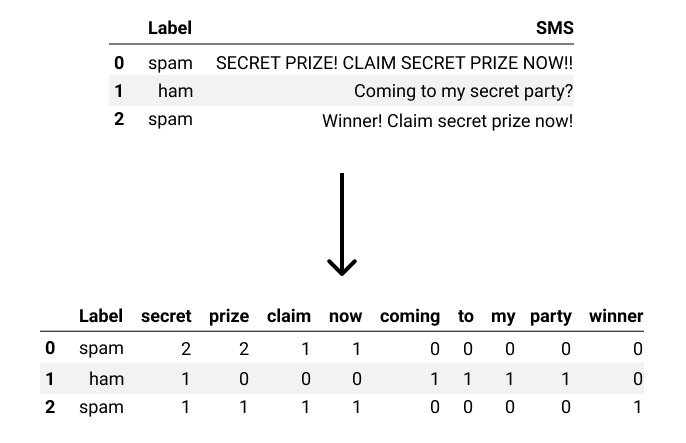

About the transformation above, notice that:
- the _SMS_ column is replaced by a seires of new  columns, where each column represents a unique word from the vocabulary.
- Each row describes a single message, and the number in each cell is the counts of that word occurrence in the each row. For example, the first row (in the above picture) corresponds to message "SECRET PRIZE! CLAIM SECRET PRIZE NOW!!", and it has the values _spam, 2, 2, 1, 1, 0, 0, 0, 0, 0_. These values tell us that:
    - the message is spam
    - the word "secret" occurs twice
    - the word "price" occurs twice
    - the word "claim" occurs once
    - the word "now" occurs once
    - the word "coming", "to", "my", "party", "winnter" never occurs in the message

### i. Strip the punctuation and convert all words to lower case

In [431]:
train_set['SMS'] = train_set['SMS'].str.replace('\W', ' ').str.lower() #remove any non word characters 
#except whitespace
print(train_set.head(20))
print(len(train_set))

   Label                                                SMS
0    ham                       yep  by the pretty sculpture
1    ham      yes  princess  are you going to make me moan 
2    ham                         welp apparently he retired
3    ham                                            havent 
4    ham  i forgot 2 ask ü all smth   there s a card on ...
5    ham  ok i thk i got it  then u wan me 2 come now or...
6    ham  i want kfc its tuesday  only buy 2 meals only ...
7    ham                         no dear i was sleeping   p
8    ham                          ok pa  nothing problem   
9    ham                    ill be there on   lt   gt   ok 
10   ham  my uncles in atlanta  wish you guys a great se...
11   ham                                           my phone
12   ham                       ok which your another number
13   ham  the greatest test of courage on earth is to be...
14   ham  dai what this da   can i send my resume to thi...
15   ham                      i am late 

<ipython-input-431-988ad7477dca>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_set['SMS'] = train_set['SMS'].str.replace('\W', ' ').str.lower() #remove any non word characters


### ii. Extract unique words

In [432]:
vocabulary = [] #list containing all unique vocabulary
train_set['SMS'] = train_set['SMS'].str.split()
for list_of_words in train_set['SMS']:
    for word in list_of_words:
        vocabulary.append(word)
vocabulary = set(vocabulary) #convert to set to select unique words only
vocabulary = list(vocabulary) #convert back to list
len(vocabulary)

<ipython-input-432-32a341e0f9b5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_set['SMS'] = train_set['SMS'].str.split()


7783

### iii. Count number of occurrence of each word in vocabulary in each sms

In [433]:
#Initialize a dictionary in which each word in vocabluary is set to 0 for each SMS
word_counts_per_sms = {unique_word: [0] * len(train_set['SMS']) for unique_word in vocabulary}
for index, sms in enumerate(train_set['SMS']):
    for word in sms:
        word_counts_per_sms[word][index] += 1

word_counts_per_sms = pd.DataFrame(word_counts_per_sms)
word_counts_per_sms.head()


,abeg,shake,verify,ericsson,8,caught,compass,molested,if,anna,...,bhaji,clock,signal,jules,having,process,load,pleasure,affairs,visiting
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [434]:
train_set = pd.concat([train_set,word_counts_per_sms], axis=1)
train_set.head()


,Label,SMS,abeg,shake,verify,ericsson,8,caught,compass,molested,...,bhaji,clock,signal,jules,having,process,load,pleasure,affairs,visiting
0,ham,"[yep, by, the, pretty, sculpture]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ham,"[yes, princess, are, you, going, to, make, me,...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,ham,"[welp, apparently, he, retired]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,ham,[havent],0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,ham,"[i, forgot, 2, ask, ü, all, smth, there, s, a,...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 4. Apply Naive Bayes Algorithm

### Recap

Let's first review the Bayes Theorem. We know from our Probability and Statistics class that Bayes Theorem states that: given class $y$ and features $x_i (i = 1,2,...,n)$
<font size="+1"><center>$P(y | x_1, x_2,...,x_n) = \frac{P(y)P(x_1,x_2,...,x_n | y)}{P(x_1,x_2,...,x_n)}$</center></font>

The "Naive" condition stems from the assumption that $x_1, x_2,...,x_n$ are independents i.e:
<font size="+1"><center>$P(x_i | y,x_1,...,x_{i-1},x_{i+1},...,x_n) = P(x_i | y)$</center></font>

This simplifies eq above to:
<font size="+1"><center>$P(y | x_1, x_2,...,x_n) = \frac{P(y)\prod_{i=1}^nP(x_i | y)}{P(x_1,x_2,...,x_n)}$</center></font>

Since the denominator is the same for other classes computation, we only care: 
<font size="+1"><center>$P(y | x_1, x_2,...,x_n)\propto P(y)\prod_{i=1}^nP(x_i | y)$</center></font>


### Implementation

In this project, we have $y = \{Spam, Ham\}$ and $x_1,x_2,...,x_n$ are actually words/vocabulary in each text, hence they become $w_1,w_2,...,w_n$. Therefore the equation for each class becomes:

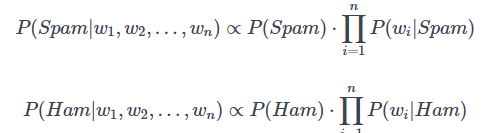

And as we doing __Multinomial Bayes__, $P(w_{i}|Spam)$ and $P(w_{i}|Ham)$ is calculated as:
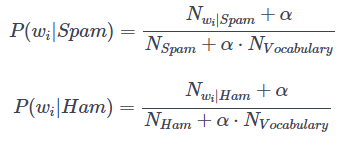
Let's also summarize what the terms in the equations above mean:
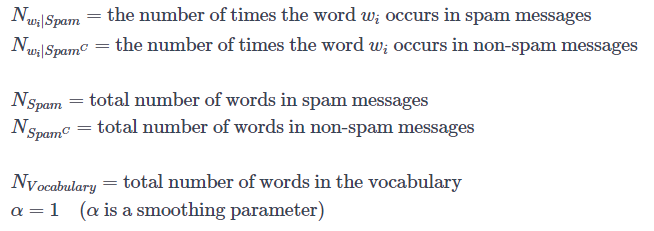


### Calculate constant values
Some of the terms in the 4 equations above will have same value for every new message. Let's calculate __$P(Ham)$__, __$P(Spam)$__, __$N_{Spam}$__, $N_{Ham}$ and __$N_{Vocabulary}$__

In [435]:
p_ham = (train_set['Label'] == 'ham').sum()/len(train_set) #P(Ham)
p_spam = (train_set['Label'] == 'spam').sum()/len(train_set) #P(Spam)

print("Spam probability = ", p_spam)
print("Ham probability = ", p_ham)

Spam probability =  0.13458950201884254
Ham probability =  0.8654104979811574


In [436]:
spam_sms = train_set[train_set['Label'] == 'spam'].iloc[:,2:]
N_spam = spam_sms.sum().sum() #N_spam: number of words in spam messages
print(N_spam)

15190


In [437]:
ham_sms = train_set[train_set['Label'] == 'ham'].iloc[:,2:]
N_ham = ham_sms.sum().sum() #N_ham: number of words in ham messages
print(N_ham)

57237


In [438]:
N_vocab = len(vocabulary) #Number of words in the vocabulary
print(N_vocab)

7783


In [439]:
alpha = 1 #Laplace soothing value

### Calculate $P(w_{i}|Spam)$ and $P(w_{i}|Ham)$ for each $w_{i}$ in vocabulary 
Initialize 2 dictionaries. One stores the parameters for P(w|Spam) and the other for P(w|Ham). Each dictionary holds a key-value pair in which key is a word represented as a string and value is the probability of that word in spam or ham message

In [440]:
#Initlize 2 dictionaries
p_word_spam = {unique_word: 0 for unique_word in vocabulary} #containing prob of each word given a spam 
p_word_ham = {unique_word: 0 for unique_word in vocabulary} #containing prob of each word given a ham

In [441]:
train_set_spam = train_set[train_set['Label'] == 'spam']
train_set_ham = train_set[train_set['Label'] == 'ham']

In [442]:
#Calculuate P(w|Spam)

#Our train_set DataFrame already contains columns of unique word and counts for 
#each word in each sms
for word in vocabulary:
    N_word_given_spam = train_set_spam[word].sum()
    p_word_spam[word] = (N_word_given_spam + alpha)/(N_spam + alpha*N_vocab)

#Calculate P(w|Ham)

for word in vocabulary:
    N_word_given_ham  = train_set_ham[word].sum()
    p_word_ham[word] = (N_word_given_ham + alpha)/(N_ham + alpha*N_vocab)
    

### Write classify() function 
We have caluclated all the parameters needed so far. It's time to start creating the spam filter. The spam filter works as follow:
- Takes in as input a new message(w1, w2,...,wn)
- Calculates $P(Spam|w_1, w_2, ..., w_n)$ and $P(Ham|w_1, w_2, ..., w_n)$
- Compares the values of $P(Spam|w_1, w_2, ..., w_n)$ and $P(Ham|w_1, w_2, ..., w_n)$, and:

    * If $P(Ham|w_1, w_2, ..., w_n) > P(Spam|w_1, w_2, ..., w_n)$, then the message is classified as ham.

    * If $P(Ham|w_1, w_2, ..., w_n) < P(Spam|w_1, w_2, ..., w_n)$, then the message is classified as spam.

    * If $P(Ham|w_1, w_2, ..., w_n) = P(Spam|w_1, w_2, ..., w_n)$, then the algorithm may request human help.

In [443]:
import re

def classify(message):

    #Preprocessing
    #Remove punctuation, convert to lower case and split message into list of words
    message = re.sub('\W', ' ', message)
    message = message.lower()
    message = message.split()

    p_spam_given_message = p_spam
    p_ham_given_message = p_ham
    
    for word in message:
        if word in p_word_spam:
            p_spam_given_message *= p_word_spam[word]
        if word in p_word_ham:
            p_ham_given_message *= p_word_ham[word]

    print('P(Spam|message):', p_spam_given_message)
    print('P(Ham|message):', p_ham_given_message)

    if p_ham_given_message > p_spam_given_message:
        print('Label: Ham')
    elif p_ham_given_message < p_spam_given_message:
        print('Label: Spam')
    else:
        print('Equal proabilities, have a human classify this!')

        

Let's run some quick test on obvious ham and spam message 

In [444]:
message = 'Sounds good, Tom, then see u there'
classify(message)

P(Spam|message): 2.4372375665888117e-25
P(Ham|message): 3.687530435009238e-21
Label: Ham


In [445]:
message = 'WINNER!! This is the secret code to unlock the money: C3421.'
classify(message)

P(Spam|message): 1.3481290211300841e-25
P(Ham|message): 1.9368049028589875e-27
Label: Spam


### Classify test set

We have created 2 basic messages to briefly test the filter above and it seems to work well, we''ll now try to determine how well them spam filter works on 1114 messages in test se. First, we need to rewrite the classify() function to return the label instead of printing

In [446]:
import re

def classify_test_set(message):
    
    #Preprocessing
    #Remove punctuation, convert to lower case and split message into list of words
    message = re.sub('\W', ' ', message)
    message = message.lower()
    message = message.split()

    p_spam_given_message = p_spam
    p_ham_given_message = p_ham
    
    for word in message:
        if word in p_word_spam:
            p_spam_given_message *= p_word_spam[word]
        if word in p_word_ham:
            p_ham_given_message *= p_word_ham[word]

    if p_ham_given_message > p_spam_given_message:
        return 'ham'
    elif p_ham_given_message < p_spam_given_message:
        return 'spam'
    else:
        return 'needs human classification'

        

We are now ready to apply the filter on the test set

In [447]:
test_set['predicted'] = test_set['SMS'].apply(classify_test_set)
test_set.head()

<ipython-input-447-8be73113c36f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set['predicted'] = test_set['SMS'].apply(classify_test_set)


,Label,SMS,predicted
0,ham,Later i guess. I needa do mcat study too.,ham
1,ham,But i haf enuff space got like 4 mb...,ham
2,spam,Had your mobile 10 mths? Update to latest Oran...,spam
3,ham,All sounds good. Fingers . Makes it difficult ...,ham
4,ham,"All done, all handed in. Don't know if mega sh...",ham


### 5. Compare the results
Now we can compare the predicted values with the actual values and we will use Accuracy as a metrics to measure how well the filter works:
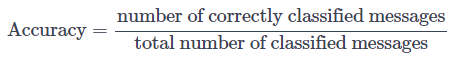

In [448]:
correct = 0
total = len(test_set)
result = (test_set['Label'] == test_set['predicted'])
correct = result.sum()

print('Correct:', correct)
print('Incorrect:', total - correct)
print('Accuracy:', correct/total)

Correct: 1100
Incorrect: 14
Accuracy: 0.9874326750448833


So we have a pretty good performance with almost 99% accuracy. Out of curiosity, let's look at messages that were wrongly classified.

In [449]:
wrong_classify_sms = test_set[test_set['Label'] != test_set['predicted']]
wrong_classify_sms[['SMS', 'predicted']]

,SMS,predicted
114,Not heard from U4 a while. Call me now am here...,ham
135,More people are dogging in your area now. Call...,ham
152,Unlimited texts. Limited minutes.,spam
159,26th OF JULY,spam
284,Nokia phone is lovly..,spam
293,A Boy loved a gal. He propsd bt she didnt mind...,needs human classification
302,No calls..messages..missed calls,spam
319,We have sent JD for Customer Service cum Accou...,spam
504,Oh my god! I've found your number again! I'm s...,ham
546,"Hi babe its Chloe, how r u? I was smashed on s...",ham


In [450]:
print(wrong_classify_sms.loc[114, 'SMS'], '\n') #should be spam
print(wrong_classify_sms.loc[504, 'SMS'],'\n') # should be spam
print(wrong_classify_sms.loc[546, 'SMS'], '\n') # should be spam
print(wrong_classify_sms.loc[152, 'SMS'], '\n') #should be ham
print(wrong_classify_sms.loc[319, 'SMS'], '\n') #should be ham

Not heard from U4 a while. Call me now am here all night with just my knickers on. Make me beg for it like U did last time 01223585236 XX Luv Nikiyu4.net 

Oh my god! I've found your number again! I'm so glad, text me back xafter this msgs cst std ntwk chg £1.50 

Hi babe its Chloe, how r u? I was smashed on saturday night, it was great! How was your weekend? U been missing me? SP visionsms.com Text stop to stop 150p/text 

Unlimited texts. Limited minutes. 

We have sent JD for Customer Service cum Accounts Executive to ur mail id, For details contact us 



At a quick glimpse, spam messages seem to have more special characters like __"!", "?", "/" etc__. We will revise our code to take into this consideration the next section to see if the algorithm improves.

## Revision 1 (Consider special characters and upper case)

In this revision, we will revise our process presented above to also count some special characters present in a message as well as ___take upper case into account___. Also, we will create functions performing each message cleaning step for better organization. In particular, we will write foollwing functions:
- __extract_special_chars()__: extract special characters except some common characters being used widely in English such as __.__(dot),  __'__(single quote) and __,__(comma)

- __extract_unique_chars()__: extract all unique word including special characters into a vocabulary

- __count_words_per_sms()__: count number of occurrence of each word in vocabulary in each sms 

- __calculate_const_values()__: Calculate constant values : __$P(Spam)$__, __$N_{Spam}$__, $N_{Ham}$ and __$N_{Vocabulary}$__

- __cal_p_word_given_spam_or_ham()__: Calculate $P(w_{i}|Spam)$ and $P(w_{i}|Ham)$

### Read data and split into test/train set

In [451]:
sms = pd.read_csv('SMSSpamCollection', sep='\t', header=None, names=['Label','SMS'])
randomized_data = sms.sample(frac=1, random_state=1)
train_set = randomized_data[:round(0.8*len(sms))]
test_set = randomized_data[len(train_set):]

test_set.reset_index(drop=True,inplace=True)
train_set.reset_index(drop=True,inplace=True)

### Extract special characters except (dot), (single quote) and (comma)

In [452]:
def extract_special_chars(message, vocab_list=None):
    # Find all special characters, this include "whitespace"
    special_chars = re.findall(r'(\W)', message)
    #Remove whitespace in the list
    special_chars = [ele for ele in special_chars if ele.strip()]
    #Remove common special chars such as (dot), (single quote) and (comma)
    special_chars = pd.Series(special_chars)
    special_chars = special_chars.drop(special_chars[(special_chars == '.') | (special_chars == "'") | (special_chars == ",")].index)
    special_chars = list(special_chars)
    
    #if a dict is passed in, append these chars to the dict
    if vocab_list != None:
        for char in special_chars:
            if char not in vocab_list:
                vocab_list.append(char)
    return special_chars

Test the extract_special_chars() function

In [453]:
text = "Oh my god! I've found your number again! I'm so glad, text me back xafter this msgs cst std ntwk chg £1.50 "
chars = extract_special_chars(text)
chars

['!', '!', '£']

### Extract unique word into a vocabulary

In [454]:
vocabulary = []
def extract_unique_chars(text, vocabulary):
    extract_special_chars(text, vocabulary) #Append special characters to dict first
    text = re.sub('\W',' ', text) #remove any non word characters except whitespace
#   text = text.lower()
    text = text.split() #Split the text with whitespace as delimiter
    for word in text:
        if word not in vocabulary:
            vocabulary.append(word)
    return
train_set["SMS"].apply(extract_unique_chars, args=(vocabulary,))
len(vocabulary)

<ipython-input-452-fda14564c6c4>:7: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  special_chars = pd.Series(special_chars)


9696

### Count occurence of each word in vocabulary for each SMS

In [455]:
def count_word_per_sms(df, vocabulary):
    word_counts_per_sms = {unique_word: [0] * len(df) for unique_word in vocabulary}
    for index, sms in enumerate(df):
        #Count special characters first
        special_chars = extract_special_chars(sms)
        for char in special_chars:
            if char in vocabulary:
                word_counts_per_sms[char][index] +=1
        
        #Count words
        sms = re.sub("\W", ' ', sms) #Remove special characters
#        sms = sms.lower()
        sms = sms.split()
        for word in sms:
            if word in vocabulary:
                word_counts_per_sms[word][index] +=1
        
    return pd.DataFrame(word_counts_per_sms)
        
    

In [456]:
word_counts_per_sms = count_word_per_sms(train_set['SMS'], vocabulary)
train_set = pd.concat([train_set,word_counts_per_sms], axis=1)
#train_set = train_set.drop(train_set.columns[1], axis=1)
train_set
#word_counts_per_sms

<ipython-input-452-fda14564c6c4>:7: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  special_chars = pd.Series(special_chars)


,Label,SMS,Yep,by,the,pretty,sculpture,?,Yes,princess,...,hides,secrets,n8,jewelry,related,trade,Arul,Dial,Bx526,Wherre
0,ham,"Yep, by the pretty sculpture",1,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ham,"Yes, princess. Are you going to make me moan?",0,0,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,ham,Welp apparently he retired,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,ham,Havent.,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,ham,I forgot 2 ask ü all smth.. There's a card on ...,0,0,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4453,ham,"Sorry, I'll call later in meeting any thing re...",0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,1,0,0,0
4454,ham,Babe! I fucking love you too !! You know? Fuck...,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4455,spam,U've been selected to stay in 1 of 250 top Bri...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
4456,ham,Hello my boytoy ... Geeee I miss you already a...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Recalculate number of vocabularies

In [457]:
def calculate_const_values(df, vocabulary):
    p_ham = (df['Label'] == 'ham').sum()/len(df) #P(Ham)
    p_spam = (df['Label'] == 'spam').sum()/len(df) #P(Spam)
    
    spam_sms = df[df['Label'] == 'spam'].iloc[:,2:]
    N_spam = spam_sms.sum().sum() #N_spam: number of words in spam messages
    
    ham_sms = df[df['Label'] == 'ham'].iloc[:,2:]
    N_ham = ham_sms.sum().sum() #N_ham: number of words in ham messages
    
    N_vocab = len(vocabulary) #Number of words in the vocabulary
    return p_ham, p_spam, N_spam, N_ham, N_vocab

p_ham, p_spam, N_spam, N_ham, N_vocab = calculate_const_values(train_set, vocabulary)
print("P(Ham): ", p_ham)
print("P(Spam): ", p_spam)
print("N_Spam: ", N_spam)
print("N_Ham: ", N_ham)
print("N_vocab: ", N_vocab)
    
          

P(Ham):  0.8654104979811574
P(Spam):  0.13458950201884254
N_Spam:  17169
N_Ham:  62230
N_vocab:  9696


### Recalculate  $P(w_{i}|Spam)$ and $P(w_{i}|Ham)$

In [458]:
def cal_p_word_given_spam_or_ham(df_train, N_spam, N_ham, N_vocab):
    #Initlize 2 dictionaries
    p_word_spam = {unique_word: 0 for unique_word in vocabulary} #containing prob of each word given a spam 
    p_word_ham = {unique_word: 0 for unique_word in vocabulary} #containing prob of each word given a ham
    
    df_train_spam = df_train[df_train['Label'] == 'spam'].iloc[:,2:]
    df_train_ham = df_train[df_train['Label'] == 'ham'].iloc[:,2:]
    
    alpha = 1
    #Calculuate P(w|Spam)
    
    #Our df_train DataFrame already contains columns of unique word and counts for 
    #each word in each sms
    for word in vocabulary:
        N_word_given_spam = df_train_spam[word].sum()
        p_word_spam[word] = (N_word_given_spam + alpha)/(N_spam + alpha*N_vocab)

    #Calculate P(w|Ham)

    for word in vocabulary:
        N_word_given_ham  = df_train_ham[word].sum()
        p_word_ham[word] = (N_word_given_ham + alpha)/(N_ham + alpha*N_vocab)
        
    return p_word_spam, p_word_ham

p_word_spam, p_word_ham = cal_p_word_given_spam_or_ham(train_set, N_spam, N_ham, N_vocab)

### Classify test set

In [459]:
def classify_test_set(message):
    p_spam_given_message = p_spam
    p_ham_given_message = p_ham
    
    special_chars = extract_special_chars(message)
    for char in special_chars:
        if char in p_word_spam:
            p_spam_given_message *= p_word_spam[char]
        if char in p_word_ham:
            p_ham_given_message *= p_word_ham[char]
            
    message = re.sub('\W', ' ', message)
#   message = message.lower()
    message = message.split()
    
    for word in message:
        if word in p_word_spam:
            p_spam_given_message *= p_word_spam[word]
        if word in p_word_ham:
            p_ham_given_message *= p_word_ham[word]

    if p_ham_given_message > p_spam_given_message:
        return 'ham'
    elif p_ham_given_message < p_spam_given_message:
        return 'spam'
    else:
        return 'needs human classification'

In [460]:
test_set['predicted'] = test_set['SMS'].apply(classify_test_set)
test_set.head()

<ipython-input-452-fda14564c6c4>:7: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  special_chars = pd.Series(special_chars)
<ipython-input-460-8be73113c36f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set['predicted'] = test_set['SMS'].apply(classify_test_set)


,Label,SMS,predicted
0,ham,Later i guess. I needa do mcat study too.,ham
1,ham,But i haf enuff space got like 4 mb...,ham
2,spam,Had your mobile 10 mths? Update to latest Oran...,spam
3,ham,All sounds good. Fingers . Makes it difficult ...,ham
4,ham,"All done, all handed in. Don't know if mega sh...",ham


### Calculate Accuracy

In [461]:
correct = 0
total = len(test_set)
result = (test_set['Label'] == test_set['predicted'])
correct = result.sum()

print('Correct:', correct)
print('Incorrect:', total - correct)
print('Accuracy:', correct/total)

Correct: 1100
Incorrect: 14
Accuracy: 0.9874326750448833


In [462]:
wrong_classify_sms = test_set[test_set['Label'] != test_set['predicted']]
wrong_classify_sms[['SMS', 'predicted']]

,SMS,predicted
114,Not heard from U4 a while. Call me now am here...,ham
115,1Apple/Day=No Doctor. 1Tulsi Leaf/Day=No Cance...,spam
284,Nokia phone is lovly..,spam
293,A Boy loved a gal. He propsd bt she didnt mind...,needs human classification
319,We have sent JD for Customer Service cum Accou...,spam
323,CHEERS U TEX MECAUSE U WEREBORED! YEAH OKDEN H...,spam
363,Email AlertFrom: Jeri StewartSize: 2KBSubject:...,ham
504,Oh my god! I've found your number again! I'm s...,ham
546,"Hi babe its Chloe, how r u? I was smashed on s...",ham
605,staff.science.nus.edu.sg/~phyhcmk/teaching/pc1323,spam


__Observations__: The algoritm does not improve at all as accuracy stays the same (~99%).

## Using sklearn packakge: MultinomialNB, GaussianNB, ComplementNB

Fortunately, in real work we do not need to implement the Naive Bayes algorithm from scratch like we have been doing so far. __sklearn__ package in Python provides different built-in Naive Bayes model. We will first use __MultinomialNB__ to implement multinomial Naive Bayes and to check if the built-in package gives us the same performance. After that, we will try other forms of Naive Bayes such as __GaussianNB__ and __ComplementNB__ for educational purpose:

In __GaussianNB__: The distribution of features is assumed to be Gaussian
<font size="+1"><center>$P(x_i | y) = \frac{1}{\sqrt{2\pi\sigma^{2}_{y}}}exp (\frac{-(x_i - \mu_{y})^{2}}{2\sigma^{2}_{y}})$</center></font>

__ComplementNB__(CNB) is an adaptation of standard multinomial NB suited for imbalanced data sets. For more details, refer to: https://scikit-learn.org/stable/modules/naive_bayes.html 

For this part, we will also take special characters and upper case into account.

### Encode the label columns

For the NB to work, we need to encode the __Label__ columns into 0 (ham) and 1 (spam) on both train and test set. The package __LabelEncoder__ ease this process.

In [463]:
from sklearn.preprocessing import LabelEncoder
features = train_set.iloc[:,2:].columns
target = 'Label'

le = LabelEncoder()
train_set[target] = le.fit_transform(train_set[target]) #Encode label in train set
test_set[target] = le.fit_transform(test_set[target]) #Encode label in test set
test_set = test_set.drop('predicted', axis=1) #Drop the predicted column created from previous step
test_set.head()

<ipython-input-463-5905ce2277ea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set[target] = le.fit_transform(test_set[target]) #Encode label in test set


,Label,SMS
0,0,Later i guess. I needa do mcat study too.
1,0,But i haf enuff space got like 4 mb...
2,1,Had your mobile 10 mths? Update to latest Oran...
3,0,All sounds good. Fingers . Makes it difficult ...
4,0,"All done, all handed in. Don't know if mega sh..."


### Create features on test set

We to append all words in our vocabulary (created from train_set) and count the number of occurrence of each word in test set.

In [464]:
word_counts_per_sms = count_word_per_sms(test_set['SMS'], vocabulary)
test_set = pd.concat([test_set,word_counts_per_sms], axis=1)
test_set.head()


<ipython-input-452-fda14564c6c4>:7: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  special_chars = pd.Series(special_chars)


,Label,SMS,Yep,by,the,pretty,sculpture,?,Yes,princess,...,hides,secrets,n8,jewelry,related,trade,Arul,Dial,Bx526,Wherre
0,0,Later i guess. I needa do mcat study too.,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,But i haf enuff space got like 4 mb...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,Had your mobile 10 mths? Update to latest Oran...,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,All sounds good. Fingers . Makes it difficult ...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,"All done, all handed in. Don't know if mega sh...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Train and Test

Define a train and test function with NB and the options for a specific type of NB. 

In [465]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB
def train_and_test_NB(X_train, X_test, y_train, y_test, model):
    #Create a model based on user's choice
    if model == "Multinomial":
        nb = MultinomialNB()
    elif model == "Gaussian":
        nb = GaussianNB()
    elif model == "Complement":
        nb = ComplementNB()
    else:
        print("Invalid model!")
        return

    #train and test
    nb.fit(X_train, y_train)
    y_pred = nb.predict(X_test)
    
    #Calculate accuracy
    correct = 0
    total = len(X_test)
    result = (y_test == y_pred)
    correct = result.sum()
    
    print("{} Naive Bayes:".format(model))
    print('Correct:', correct)
    print('Incorrect:', total - correct)
    print('Accuracy:', correct/total)
    return

In [466]:
#MultinomialNB
train_and_test_NB(train_set.iloc[:,2:], test_set.iloc[:,2:] , train_set[target], test_set[target], "Multinomial")
print('\n')
#GaussianNB
train_and_test_NB(train_set.iloc[:,2:], test_set.iloc[:,2:] , train_set[target], test_set[target], "Gaussian")
print('\n')
#ComplementNB
train_and_test_NB(train_set.iloc[:,2:], test_set.iloc[:,2:] , train_set[target], test_set[target], "Complement")

Multinomial Naive Bayes:
Correct: 1101
Incorrect: 13
Accuracy: 0.9883303411131059


Gaussian Naive Bayes:
Correct: 1037
Incorrect: 77
Accuracy: 0.9308797127468582


Complement Naive Bayes:
Correct: 1084
Incorrect: 30
Accuracy: 0.9730700179533214


__Observations__: The MultinomialNB()'s performance is just slightly better then our raw implentation (13 incorretly misclassified versus 14). Other NB types are way worse than multinomal (93% and 97% accuracy for Gaussian and Complement respectively).

This provides some assurances that our implementation-from-scratch of multinomial NB is correct. 

## Conclusion

We've built a simple, yet effective spam filter using Naive Bayes Algorithm with accuracy about __98.7%__. In first attempt, we ignored upper case and special characters.

We've spent some more efforts in investigating the wrongly classiifed messages and tried to improve our algorithm by taking upper case and special characters into account, but the performance is not improved. We probably need a smarter way to clean the message or maybe a bigger train set to increase our vocabulary dictionary. 

We've verified our implemention-from-scratch by comparing the results with results got from built-in sklearn package. It's also confirmed that Multinomal NB is the best suited type of NB in this project.